## RNNT를 구현 및 이용하기 위한 사전지식(Pre-knowledge to implement or use RNNT Net)

---

1. 논문(Paper)
     * [CTC(Connectionist Temporal Classification)](https://www.cs.toronto.edu/~graves/icml_2006.pdf])
     * [Beam Search Decoding](https://aclanthology.org/W17-3207.pdf)
     * [RNN-T](https://arxiv.org/pdf/1211.3711.pdf)

2. 관련링크(Related links)
     * https://ratsgo.github.io/speechbook/docs/neuralam/ctc
     * [Beam Search Decoding](https://amber-chaeeunk.tistory.com/94)
     * [Beam Search for Rnn-t ASR](https://www.youtube.com/watch?v=Siuqi7e9IwU)
     * [Greedy Decoding for RNN-T ASR](https://www.youtube.com/watch?v=dgsDIuJLoJU)

In [ ]:
!pip install sentencepiece
!pip install python-Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!wget https://www.openslr.org/resources/12/train-clean-100.tar.gz

--2023-05-03 05:08:10--  https://www.openslr.org/resources/12/train-clean-100.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://us.openslr.org/resources/12/train-clean-100.tar.gz [following]
--2023-05-03 05:08:10--  http://us.openslr.org/resources/12/train-clean-100.tar.gz
Resolving us.openslr.org (us.openslr.org)... 46.101.158.64
Connecting to us.openslr.org (us.openslr.org)|46.101.158.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6387309499 (5.9G) [application/x-gzip]
Saving to: ‘train-clean-100.tar.gz’

train-clean-100.tar 100%[===================>]   5.95G  19.3MB/s    in 5m 26s  

2023-05-03 05:13:37 (18.7 MB/s) - ‘train-clean-100.tar.gz’ saved [6387309499/6387309499]



In [ ]:
!wget https://www.openslr.org/resources/12/test-clean.tar.gz

--2023-05-09 01:41:26--  https://www.openslr.org/resources/12/test-clean.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://us.openslr.org/resources/12/test-clean.tar.gz [following]
--2023-05-09 01:41:26--  http://us.openslr.org/resources/12/test-clean.tar.gz
Resolving us.openslr.org (us.openslr.org)... 46.101.158.64
Connecting to us.openslr.org (us.openslr.org)|46.101.158.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 346663984 (331M) [application/x-gzip]
Saving to: ‘test-clean.tar.gz.1’

test-clean.tar.gz.1 100%[===================>] 330.60M  27.4MB/s    in 13s     

2023-05-09 01:41:39 (25.8 MB/s) - ‘test-clean.tar.gz.1’ saved [346663984/346663984]



In [ ]:
!wget https://www.openslr.org/resources/12/dev-clean.tar.gz

--2023-05-09 01:41:39--  https://www.openslr.org/resources/12/dev-clean.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://us.openslr.org/resources/12/dev-clean.tar.gz [following]
--2023-05-09 01:41:40--  http://us.openslr.org/resources/12/dev-clean.tar.gz
Resolving us.openslr.org (us.openslr.org)... 46.101.158.64
Connecting to us.openslr.org (us.openslr.org)|46.101.158.64|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337926286 (322M) [application/x-gzip]
Saving to: ‘dev-clean.tar.gz.1’

dev-clean.tar.gz.1  100%[===================>] 322.27M  27.5MB/s    in 12s     

2023-05-09 01:41:52 (26.0 MB/s) - ‘dev-clean.tar.gz.1’ saved [337926286/337926286]



In [ ]:
!tar xvzf train-clean-100.tar.gz

In [ ]:
!tar xvzf dev-clean.tar.gz

In [ ]:
!tar xvzf test-clean.tar.gz

In [ ]:
import torch
from torch import nn
import numpy as np
from torchaudio.models import RNNT,Emformer,emformer_rnnt_base,emformer_rnnt_model
from torch import optim
import torch
from torch import nn 
import torch.nn.functional as F
from torchaudio import functional as audioF
from torchaudio import transforms as audioT
import torchaudio
import Levenshtein as Lev

In [ ]:
import numpy as np
import torch
from torch import nn
from glob import glob
import librosa
from tqdm import tqdm
import soundfile as sf
import os
import random
from pathlib import Path

In [ ]:
def wer(s1,s2):
  b = set(s1.split()+s2.split())
  word_map = dict(zip(b,range(len(b))))
  print("word_map:",word_map)
  w1 = [chr(word_map[w]) for w in s1.split()]
  w2 = [chr(word_map[w]) for w in s2.split()]
  dev = max(len(s2.split()),1)
  score = Lev.distance("".join(w1),"".join(w2))/dev
  return score

def cer(s1,s2):
  w1 = s1.replace(" ","")
  w2 = s2.replace(" ","")
  dev = max(len(s2),1)
  score = Lev.distance((w1),(w2))/dev
  return score

In [ ]:
class DataLoader:
    def __init__(self,batch_size=1,is_test_set=False):
        super().__init__()
        self.batch_size = batch_size
        self.is_test_set = is_test_set
        common_folder = "LibriSpeech/dev-clean"#"LibriSpeech/train-clean-100"
        if(is_test_set==True):
          common_folder = "LibriSpeech/test-clean"
        transcripts_files = glob(os.path.join(common_folder,"*/*/*.txt"),recursive=True)
        audio_files = glob(os.path.join(common_folder,"*/*/*.flac"),recursive=True)
        if(is_test_set==False):
          audio_files_len = len(audio_files)
          audio_files = audio_files[:audio_files_len//15]
        print("transcripts_files:",len(transcripts_files))
        print("audio_files:",len(audio_files))
        transcripts = {}
        for ts_fpath in transcripts_files:
          with open(ts_fpath,"r") as fp:
              txt = fp.read().split("\n")
              for ln in txt:
                  if(ln.strip()==""):
                      continue
                  lines = ln.split(" ")
                  fn = lines[0]
                  lbls = list(" ".join(lines[1:]).upper())
                  transcripts[fn] = lbls
        self.audio_files = audio_files
        self.transcript_keys = list(transcripts.keys())
        self.transcript_table = "".join([chr(ord("A")+i) for i in range(26)])+(" .'!?")
        #print("transcript",transcripts)
        #print("transcript keys:",self.transcript_keys)
        
        self.transcripts = transcripts
        self._audio_file_len = len(self.audio_files)
        if(is_test_set==False):
          self.shuffleDataset()

    def __len__(self):
        tmp = len(self.audio_files)
        return tmp//self.batch_size
    def _loadFeature(self,fpath):
        rawinput,sample_rate = sf.read(fpath)
        rawinput = abs(rawinput)
        mfcc = librosa.feature.mfcc(y=rawinput,sr=sample_rate,n_mfcc=96).T
        
        return mfcc
    def _convertTranscript2(self,text_list,with_blank=False):
        result = []
        for char in text_list:
            result.append(self.transcript_table.find(char)+1)
            if(with_blank==True):
              result.append(0)
        return result
    def shuffleDataset(self):
        random.shuffle(self.audio_files)
    def token2String(self,token_list,with_visible_tag=True):
      result = ""
      max_len = len(self.transcript_table)+1
      for i in range(len(token_list)):
        token_id = token_list[i]
        if(token_id==0):
          result+='<s>' if(with_visible_tag==True) else ""
        elif(0<token_id<max_len):
          result+= self.transcript_table[token_id-1]
        else:
          result+='</u?>' if(with_visible_tag==True) else ""
      return result
    def __paddingWithMaxSpecTimeLength(self,specs):
        maxlen = max(specs,key=lambda x: x.shape[0])
        maxlen = maxlen.shape[0]
        for i in range(len(specs)):
          specs[i] = np.pad(specs[i],((0,maxlen-specs[i].shape[0]),(0,0)))
        return specs#,real_length
    def __paddingTranscriptWithMaxLength(self,transcripts):
        maxlen = max(transcripts,key=lambda x:len(x))
        maxlen = len(maxlen)
        for i in range(len(transcripts)):
          #real_length = specs[i].shape[0]
          transcripts[i] = np.pad(transcripts[i],(0,maxlen-len(transcripts[i])))
        return transcripts#,real_length
    def __getitem__(self,idx):
        if(idx>=self.__len__()):
            raise StopIteration()
        start_index,end_cond = (idx*self.batch_size,min((idx+1)*self.batch_size,(self._audio_file_len)))
        #print((start_index,end_cond))
        specs = []
        transcripts = []
        transcript_lengths = []
        specs_lengths = []

        for i in range(start_index,end_cond):
            fpath = self.audio_files[i]
            feature = self._loadFeature(fpath)
            fn = Path(fpath).stem
            specs.append(torch.from_numpy(feature))
            specs_lengths.append(feature.shape[0])
            transcript_indices = self._convertTranscript2(self.transcripts[fn],with_blank=False)#+[0]
            transcripts.append(torch.from_numpy(np.array(transcript_indices)))
            transcript_lengths.append(len(transcript_indices))#-1)
        
        transcript_lengths = np.array(transcript_lengths)
        specs_lengths = np.array(specs_lengths)
        return specs,specs_lengths,transcripts,transcript_lengths

transcripts_files: 97
audio_files: 135


  0%|          | 0/9 [00:00<?, ?it/s]

	 (-3.4079048026942855, 5.17011047404732)


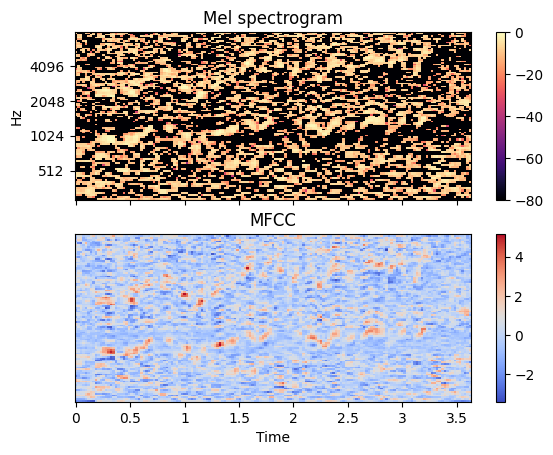

 11%|█         | 1/9 [00:01<00:09,  1.18s/it]

	 (-4.157248147285877, 5.505436373116435)


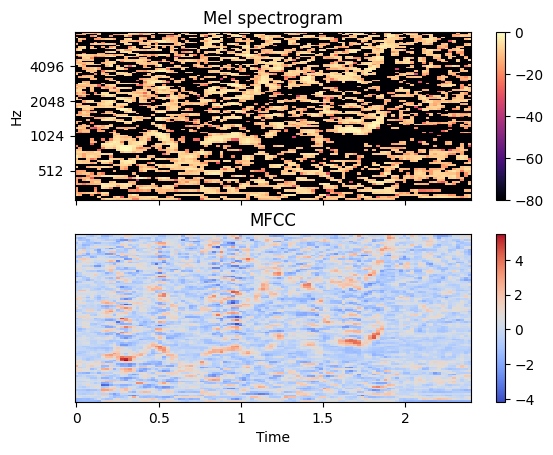

 22%|██▏       | 2/9 [00:02<00:07,  1.07s/it]

	 (-4.206738126591872, 6.137800236769488)


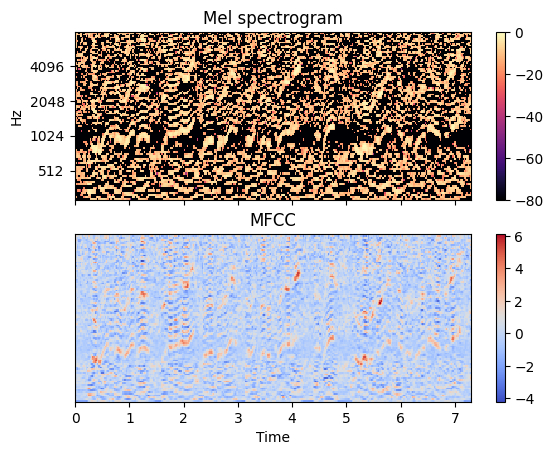

 33%|███▎      | 3/9 [00:03<00:06,  1.07s/it]

	 (-3.9025827627431724, 8.078864370718813)


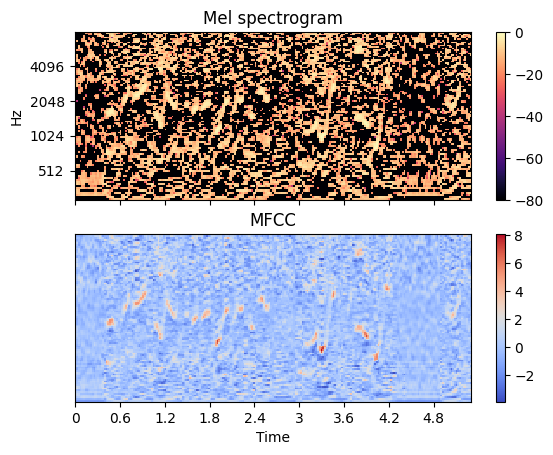

 44%|████▍     | 4/9 [00:04<00:05,  1.09s/it]

	 (-3.9998108854231242, 5.385835369306509)


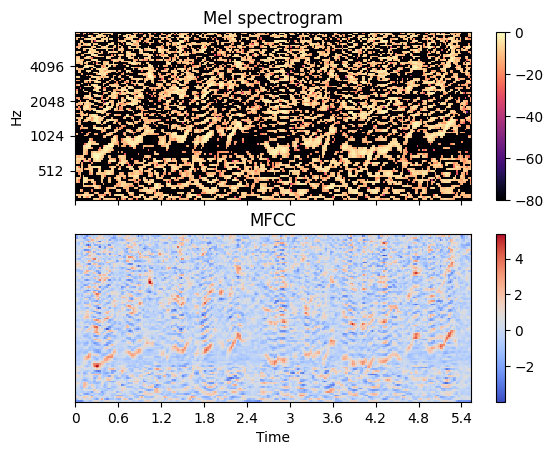

 56%|█████▌    | 5/9 [00:05<00:04,  1.16s/it]

	 (-3.5948315594522158, 7.129199562253097)


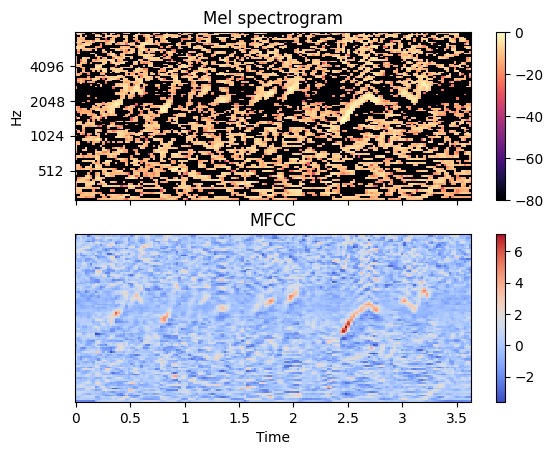

 67%|██████▋   | 6/9 [00:07<00:04,  1.37s/it]

	 (-3.5499742151984255, 6.013201241770885)


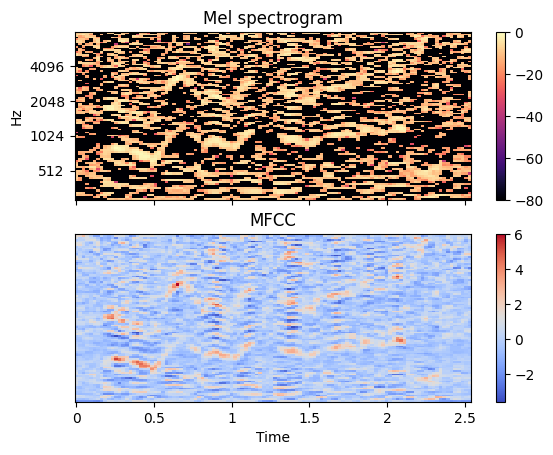

 78%|███████▊  | 7/9 [00:08<00:02,  1.24s/it]

	 (-3.714109990381032, 4.595412138797804)


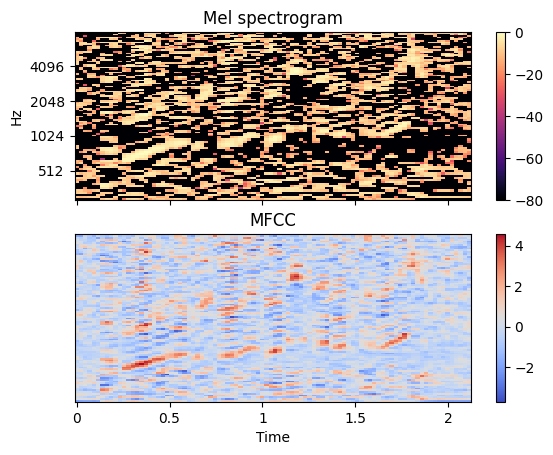

 89%|████████▉ | 8/9 [00:09<00:01,  1.16s/it]

	 (-4.4360208706427, 6.645315168300631)


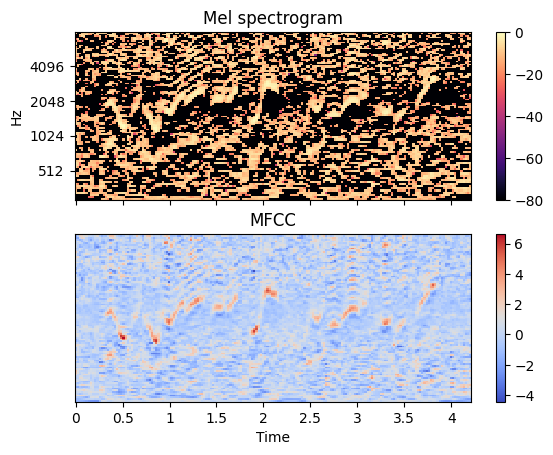

100%|██████████| 9/9 [00:10<00:00,  1.16s/it]


In [ ]:
if(__name__=="__main__"):
    traindataset_loader = DataLoader(15)
    from matplotlib import pyplot as plt
    index = 0
    for specs,specs_lengths,transcripts,transcript_lengths in tqdm(traindataset_loader):
        #print(specs.shape,specs_lengths.shape,transcripts.shape,transcript_lengths.shape)
        fig, ax = plt.subplots(nrows=2, sharex=True)
        mfcc= specs[0].numpy().T
        print("\t",(np.min(mfcc),np.max(mfcc)))
        img = librosa.display.specshow(librosa.power_to_db(mfcc, ref=np.max),
                                      x_axis='time', y_axis='mel',fmin=100, fmax=8000,
                                      ax=ax[0])
        fig.colorbar(img, ax=[ax[0]])
        ax[0].set(title='Mel spectrogram')
        ax[0].label_outer()
        img = librosa.display.specshow(mfcc, x_axis='time', ax=ax[1])
        fig.colorbar(img, ax=[ax[1]])
        ax[1].set(title='MFCC')
        plt.show()
        if(index>20):
          break
        index+=1


## Temporary CTC Network(for Practice)

In [ ]:
class CTCNet(nn.Module):
  def __init__(self,in_dim,hidden_dim,out_dim):
    super().__init__()
    self._in_dim = in_dim
    self._hidden_dim = hidden_dim
    self._out_dim = out_dim
    self._lstms = nn.ModuleList([
        nn.LSTM(in_dim,hidden_dim,num_layers=1),
        nn.LSTM(hidden_dim,hidden_dim,num_layers=1),
        nn.LSTM(hidden_dim,hidden_dim,num_layers=1),
        #nn.LSTM(hidden_dim,hidden_dim,num_layers=2),
        ])
    #"""
    self._hidden_linears = nn.ModuleList([
        
        nn.Sequential( nn.Linear(hidden_dim,hidden_dim),nn.LayerNorm(hidden_dim),nn.ReLU(inplace=True)) if(i+1<len(self._lstms)) else nn.Linear(hidden_dim,out_dim)
        for i in range(len(self._lstms))
    ])
    #"""
    #self._linear = nn.Linear(hidden_dim,out_dim)


  def forward(self,x,x_len):
    opt,opt_len = x,x_len
    for i in range(len(self._lstms)):
      opt = nn.utils.rnn.pack_padded_sequence(opt,opt_len,batch_first=True,enforce_sorted=True)
      #self._lstm.flatten_parameters()
      opt,info = self._lstms[i](opt)
      opt,opt_len = nn.utils.rnn.pad_packed_sequence(opt,batch_first=True)
      opt = self._hidden_linears[i](opt)
    #opt = self._linear(opt)
    return opt,opt_len

In [ ]:
import gc
del net
gc.collect()

14017

In [ ]:
net = CTCNet(96,256,32)

In [ ]:
def predict(net,dataset):
  net.eval()
  state = None
  with torch.no_grad():
    for (features,feat_lens,labels,label_lens) in dataset:
      #features = torch.from_numpy(features)
      feat_lens = torch.from_numpy(feat_lens)
      #labels = torch.from_numpy(labels)
      label_lens = torch.from_numpy(label_lens)
      features = nn.utils.rnn.pad_sequence(features,batch_first=True)#.unsqueeze(1).transpose(2, 3)
      labels = nn.utils.rnn.pad_sequence(labels,batch_first=True)
      print(features.shape,labels.shape)
      output,output_len = net(features.float(),feat_lens)  # (batch, time, n_class)
      print("output:",output.shape)
      output = output.argmax(dim=-1)
      output = output.numpy().tolist()


      print("-"*10)
      print("\toriginal:",labels)
      #with_visible_tag
      ori_string = dataset.token2String(labels.numpy()[0].tolist())
      pred_string = dataset.token2String(output[0])
      print("\tori string: ",ori_string)
      print("\toutput result:",output[0][0])
      print("\topt string: ",pred_string)
      ori_string = dataset.token2String(labels.numpy()[0].tolist(),with_visible_tag=False)
      pred_string = dataset.token2String(output[0],with_visible_tag=False)
      print(f"\topt' string: '{pred_string}'")
      print("\twer:",wer(pred_string,ori_string))
      print("\tcer:",cer(pred_string,ori_string))
  

In [ ]:
del optimizer,criterion,traindataset,testdataset

Hyper Parameters를 정상적으로 설정한 이후, Epoch 를 100번 이상 돌려야 Only Blank 예측 문제가 어느 정도 해결됨

In [ ]:
if(__name__=="__main__"):
    initial_learning_rate = 0.0001
    max_num_epoch = 20
    optimizer = optim.Adam(net.parameters(),lr=initial_learning_rate)#,rho=0.95,eps=1e-8,weight_decay=0.0)
    criterion = nn.CTCLoss(blank=0,zero_infinity=False,reduction='sum')
    #criterion =  #audioT.RNNTLoss(blank=0,fused_log_softmax=False,reduction='mean')#'sum')
    traindataset = DataLoader(5)
    testdataset = DataLoader(1,is_test_set=True)
    #predict(net,testdataset)
    net.train()
    for epoch in range(max_num_epoch):
        index = 0
        traindataset.shuffleDataset()
        losses = []
        for (features,feat_lens,labels,label_lens) in tqdm((traindataset)):

            feat_lens,label_lens = torch.from_numpy(feat_lens),torch.from_numpy(label_lens)

            features = nn.utils.rnn.pad_sequence(features,batch_first=True)#.unsqueeze(1).transpose(2, 3)
            labels = nn.utils.rnn.pad_sequence(labels,batch_first=True)

            sorted_lens,indices = torch.sort(feat_lens.view(-1),dim=0,descending=True)
            features = features[indices]
            labels = labels[indices]
            feat_lens = sorted_lens
            label_lens = label_lens[indices]

            optimizer.zero_grad()
            
            output,output_len = net(features.float(),feat_lens)  # (batch, time, n_class)
            
            output = (torch.nn.Softmax(dim=-1)(output))
            output = output.log()#temp log softmax
            #outputs = nn.functional.log_softmax(joint_outputs,dim=-1)

            output = output.transpose(0, 1) # (time, batch, n_class)

            loss = criterion(output, labels, output_len, label_lens)
            
            loss.backward()
            
            optimizer.step()
            losses.append(loss.item())
            if(index%5==0):
                print(loss.item())
            index+=1
        print(f"ep={epoch}] loss= ",np.mean(losses))
    predict(net,testdataset)

transcripts_files: 97
audio_files: 180
transcripts_files: 87
audio_files: 2620


  3%|▎         | 1/36 [00:04<02:23,  4.10s/it]

681.10302734375


 17%|█▋        | 6/36 [00:20<01:51,  3.70s/it]

1024.38623046875


 31%|███       | 11/36 [00:39<01:20,  3.21s/it]

919.9166259765625


 44%|████▍     | 16/36 [00:53<00:59,  2.99s/it]

1222.569580078125


 58%|█████▊    | 21/36 [01:07<00:43,  2.87s/it]

764.8487548828125


 72%|███████▏  | 26/36 [01:23<00:30,  3.10s/it]

901.4133911132812


 86%|████████▌ | 31/36 [01:55<00:30,  6.18s/it]

1178.323974609375


100%|██████████| 36/36 [02:15<00:00,  3.76s/it]


895.855712890625
ep=0] loss=  956.6099836561415


  3%|▎         | 1/36 [00:07<04:32,  7.79s/it]

1217.5211181640625


 17%|█▋        | 6/36 [00:32<02:25,  4.85s/it]

996.155029296875


 31%|███       | 11/36 [00:45<01:11,  2.88s/it]

673.3250122070312


 44%|████▍     | 16/36 [01:11<01:31,  4.59s/it]

900.3175048828125


 58%|█████▊    | 21/36 [01:25<00:44,  2.98s/it]

863.733154296875


 72%|███████▏  | 26/36 [01:38<00:29,  2.95s/it]

917.9771728515625


 86%|████████▌ | 31/36 [01:57<00:20,  4.14s/it]

1272.63671875


100%|██████████| 36/36 [02:13<00:00,  3.71s/it]


1070.71923828125
ep=1] loss=  919.2930026584202


  3%|▎         | 1/36 [00:11<06:52, 11.77s/it]

1222.0667724609375


 17%|█▋        | 6/36 [00:32<02:05,  4.20s/it]

750.166015625


 31%|███       | 11/36 [00:46<01:15,  3.01s/it]

877.4920654296875


 44%|████▍     | 16/36 [00:59<00:50,  2.52s/it]

730.0166015625


 58%|█████▊    | 21/36 [01:22<00:55,  3.73s/it]

1054.53857421875


 72%|███████▏  | 26/36 [01:33<00:25,  2.60s/it]

797.95947265625


 86%|████████▌ | 31/36 [01:49<00:15,  3.13s/it]

1001.537841796875


100%|██████████| 36/36 [02:14<00:00,  3.73s/it]


1021.656982421875
ep=2] loss=  891.1756727430555


  3%|▎         | 1/36 [00:02<01:12,  2.08s/it]

784.3682861328125


 17%|█▋        | 6/36 [00:21<01:53,  3.78s/it]

747.9122314453125


 31%|███       | 11/36 [00:37<01:16,  3.05s/it]

743.0287475585938


 44%|████▍     | 16/36 [00:57<01:19,  3.98s/it]

1353.8375244140625


 58%|█████▊    | 21/36 [01:19<01:20,  5.38s/it]

1434.3577880859375


 72%|███████▏  | 26/36 [01:40<00:44,  4.49s/it]

661.27490234375


 86%|████████▌ | 31/36 [01:59<00:18,  3.67s/it]

609.493408203125


100%|██████████| 36/36 [02:18<00:00,  3.85s/it]


876.6854248046875
ep=3] loss=  866.6681399875217


  3%|▎         | 1/36 [00:03<01:47,  3.08s/it]

718.1309814453125


 17%|█▋        | 6/36 [00:14<01:08,  2.30s/it]

703.2536010742188


 31%|███       | 11/36 [00:32<01:22,  3.30s/it]

526.2596435546875


 44%|████▍     | 16/36 [00:55<01:20,  4.03s/it]

1032.9305419921875


 58%|█████▊    | 21/36 [01:13<00:58,  3.92s/it]

868.0541381835938


 72%|███████▏  | 26/36 [01:29<00:33,  3.38s/it]

610.75390625


 86%|████████▌ | 31/36 [01:50<00:21,  4.27s/it]

944.953857421875


100%|██████████| 36/36 [02:17<00:00,  3.81s/it]


767.3876342773438
ep=4] loss=  838.0595694647895


  3%|▎         | 1/36 [00:05<03:13,  5.52s/it]

943.3456420898438


 17%|█▋        | 6/36 [00:22<01:32,  3.09s/it]

843.845458984375


 31%|███       | 11/36 [00:43<01:33,  3.74s/it]

898.61181640625


 44%|████▍     | 16/36 [01:09<01:33,  4.65s/it]

599.7635498046875


 58%|█████▊    | 21/36 [01:24<00:48,  3.21s/it]

452.7506408691406


 72%|███████▏  | 26/36 [01:46<00:45,  4.58s/it]

901.2760009765625


 86%|████████▌ | 31/36 [02:00<00:14,  2.99s/it]

548.0427856445312


100%|██████████| 36/36 [02:16<00:00,  3.78s/it]


754.0794677734375
ep=5] loss=  819.851197136773


  3%|▎         | 1/36 [00:01<01:01,  1.77s/it]

609.6018676757812


 17%|█▋        | 6/36 [00:26<02:28,  4.94s/it]

1255.6964111328125


 31%|███       | 11/36 [00:41<01:20,  3.23s/it]

953.2233276367188


 44%|████▍     | 16/36 [01:00<01:11,  3.56s/it]

1225.2706298828125


 58%|█████▊    | 21/36 [01:18<00:51,  3.44s/it]

799.1596069335938


 72%|███████▏  | 26/36 [01:34<00:29,  3.00s/it]

690.3173828125


 86%|████████▌ | 31/36 [02:00<00:22,  4.46s/it]

705.8781127929688


100%|██████████| 36/36 [02:14<00:00,  3.74s/it]


707.8262939453125
ep=6] loss=  799.6229612562391


  3%|▎         | 1/36 [00:02<01:38,  2.81s/it]

632.357666015625


 17%|█▋        | 6/36 [00:27<02:31,  5.06s/it]

918.3609008789062


 31%|███       | 11/36 [00:46<01:47,  4.31s/it]

797.3497314453125


 44%|████▍     | 16/36 [00:59<00:57,  2.87s/it]

641.1475830078125


 58%|█████▊    | 21/36 [01:19<00:56,  3.76s/it]

669.5773315429688


 72%|███████▏  | 26/36 [01:42<00:47,  4.78s/it]

891.5313720703125


 86%|████████▌ | 31/36 [01:57<00:17,  3.54s/it]

947.4219970703125


100%|██████████| 36/36 [02:17<00:00,  3.81s/it]


617.8770751953125
ep=7] loss=  772.8008278740776


  3%|▎         | 1/36 [00:02<01:30,  2.60s/it]

620.577880859375


 17%|█▋        | 6/36 [00:21<01:35,  3.18s/it]

712.6495361328125


 31%|███       | 11/36 [00:46<01:50,  4.43s/it]

628.7220458984375


 44%|████▍     | 16/36 [01:06<01:06,  3.32s/it]

397.4151916503906


 58%|█████▊    | 21/36 [01:18<00:41,  2.77s/it]

723.7329711914062


 72%|███████▏  | 26/36 [01:37<00:32,  3.24s/it]

449.27081298828125


 86%|████████▌ | 31/36 [01:54<00:20,  4.08s/it]

1026.3558349609375


100%|██████████| 36/36 [02:14<00:00,  3.75s/it]


911.43408203125
ep=8] loss=  749.0509643554688


  3%|▎         | 1/36 [00:03<01:50,  3.16s/it]

715.3543701171875


 17%|█▋        | 6/36 [00:22<01:36,  3.22s/it]

534.0504760742188


 31%|███       | 11/36 [00:41<01:22,  3.29s/it]

488.3819885253906


 44%|████▍     | 16/36 [01:05<01:25,  4.30s/it]

534.0336303710938


 58%|█████▊    | 21/36 [01:18<00:43,  2.92s/it]

689.167724609375


 72%|███████▏  | 26/36 [01:36<00:32,  3.22s/it]

603.5404663085938


 86%|████████▌ | 31/36 [01:55<00:21,  4.21s/it]

662.5604248046875


100%|██████████| 36/36 [02:14<00:00,  3.74s/it]


899.184326171875
ep=9] loss=  737.3591376410591


  3%|▎         | 1/36 [00:05<03:07,  5.36s/it]

802.1607055664062


 17%|█▋        | 6/36 [00:26<02:47,  5.60s/it]

1014.1241455078125


 31%|███       | 11/36 [00:47<02:00,  4.82s/it]

849.2589721679688


 44%|████▍     | 16/36 [01:07<01:10,  3.54s/it]

581.8757934570312


 58%|█████▊    | 21/36 [01:23<00:55,  3.73s/it]

787.1478271484375


 72%|███████▏  | 26/36 [01:41<00:31,  3.17s/it]

793.5384521484375


 86%|████████▌ | 31/36 [01:56<00:15,  3.03s/it]

732.8822631835938


100%|██████████| 36/36 [02:17<00:00,  3.82s/it]


535.3177490234375
ep=10] loss=  722.8806898328993


  3%|▎         | 1/36 [00:04<02:28,  4.23s/it]

932.6116943359375


 17%|█▋        | 6/36 [00:24<01:54,  3.82s/it]

702.1109008789062


 31%|███       | 11/36 [00:54<02:33,  6.14s/it]

1497.83837890625


 44%|████▍     | 16/36 [01:08<01:07,  3.39s/it]

670.521240234375


 58%|█████▊    | 21/36 [01:22<00:46,  3.11s/it]

858.4205322265625


 72%|███████▏  | 26/36 [01:36<00:25,  2.57s/it]

660.1876220703125


 86%|████████▌ | 31/36 [01:52<00:15,  3.19s/it]

791.191650390625


100%|██████████| 36/36 [02:14<00:00,  3.74s/it]


546.7844848632812
ep=11] loss=  705.8485811021593


  3%|▎         | 1/36 [00:02<01:37,  2.78s/it]

709.21337890625


 17%|█▋        | 6/36 [00:30<02:25,  4.83s/it]

708.3003540039062


 31%|███       | 11/36 [00:46<01:17,  3.09s/it]

424.75146484375


 44%|████▍     | 16/36 [01:00<00:53,  2.68s/it]

396.8902587890625


 58%|█████▊    | 21/36 [01:13<00:36,  2.44s/it]

425.65191650390625


 72%|███████▏  | 26/36 [01:36<00:41,  4.19s/it]

502.99688720703125


 86%|████████▌ | 31/36 [02:02<00:25,  5.01s/it]

819.1239013671875


100%|██████████| 36/36 [02:14<00:00,  3.74s/it]


614.2271118164062
ep=12] loss=  674.6064300537109


  3%|▎         | 1/36 [00:03<01:57,  3.37s/it]

631.147705078125


 17%|█▋        | 6/36 [00:22<02:00,  4.01s/it]

697.1038818359375


 31%|███       | 11/36 [00:35<01:11,  2.88s/it]

458.54168701171875


 44%|████▍     | 16/36 [00:57<01:08,  3.40s/it]

555.319091796875


 58%|█████▊    | 21/36 [01:20<01:10,  4.71s/it]

932.00732421875


 72%|███████▏  | 26/36 [01:38<00:40,  4.05s/it]

914.267822265625


 86%|████████▌ | 31/36 [01:55<00:17,  3.40s/it]

586.3284912109375


100%|██████████| 36/36 [02:12<00:00,  3.69s/it]


418.5830993652344
ep=13] loss=  654.058617485894


  3%|▎         | 1/36 [00:02<01:37,  2.79s/it]

642.6116333007812


 17%|█▋        | 6/36 [00:17<01:30,  3.03s/it]

688.8943481445312


 31%|███       | 11/36 [00:31<01:07,  2.69s/it]

343.4414367675781


 44%|████▍     | 16/36 [00:58<01:47,  5.37s/it]

770.2796630859375


 58%|█████▊    | 21/36 [01:20<01:16,  5.09s/it]

952.6334228515625


 72%|███████▏  | 26/36 [01:37<00:43,  4.31s/it]

656.4423217773438


 86%|████████▌ | 31/36 [01:49<00:14,  2.90s/it]

590.208984375


100%|██████████| 36/36 [02:13<00:00,  3.70s/it]


420.0246276855469
ep=14] loss=  635.0142389933268


  3%|▎         | 1/36 [00:03<02:15,  3.86s/it]

543.8226928710938


 17%|█▋        | 6/36 [00:25<02:16,  4.56s/it]

709.4170532226562


 31%|███       | 11/36 [00:40<01:10,  2.81s/it]

294.9539794921875


 44%|████▍     | 16/36 [00:57<00:58,  2.95s/it]

410.87408447265625


 58%|█████▊    | 21/36 [01:19<01:07,  4.48s/it]

1020.3646850585938


 72%|███████▏  | 26/36 [01:33<00:34,  3.42s/it]

671.5767211914062


 86%|████████▌ | 31/36 [01:58<00:26,  5.25s/it]

844.442626953125


100%|██████████| 36/36 [02:14<00:00,  3.75s/it]


584.1051025390625
ep=15] loss=  620.3605829874674


  3%|▎         | 1/36 [00:02<01:14,  2.12s/it]

533.7747802734375


 17%|█▋        | 6/36 [00:20<01:45,  3.52s/it]

609.1365966796875


 31%|███       | 11/36 [00:36<01:24,  3.38s/it]

702.59765625


 44%|████▍     | 16/36 [00:58<01:28,  4.43s/it]

472.3072814941406


 58%|█████▊    | 21/36 [01:22<01:13,  4.92s/it]

744.2316284179688


 72%|███████▏  | 26/36 [01:38<00:30,  3.00s/it]

323.2391357421875


 86%|████████▌ | 31/36 [01:55<00:20,  4.00s/it]

743.4616088867188


100%|██████████| 36/36 [02:17<00:00,  3.81s/it]


490.21136474609375
ep=16] loss=  596.0886137220594


  3%|▎         | 1/36 [00:02<01:16,  2.17s/it]

505.9107666015625


 17%|█▋        | 6/36 [00:15<01:24,  2.82s/it]

755.8345336914062


 31%|███       | 11/36 [00:34<01:13,  2.95s/it]

469.3462829589844


 44%|████▍     | 16/36 [00:52<00:57,  2.88s/it]

367.1927490234375


 58%|█████▊    | 21/36 [01:18<01:11,  4.78s/it]

677.9545288085938


 72%|███████▏  | 26/36 [01:34<00:28,  2.81s/it]

363.2930908203125


 86%|████████▌ | 31/36 [01:51<00:16,  3.33s/it]

643.5162963867188


100%|██████████| 36/36 [02:15<00:00,  3.76s/it]


838.0269775390625
ep=17] loss=  572.9786105685764


  3%|▎         | 1/36 [00:02<01:11,  2.04s/it]

393.7221984863281


 17%|█▋        | 6/36 [00:19<01:43,  3.45s/it]

756.4490356445312


 31%|███       | 11/36 [00:36<01:25,  3.42s/it]

424.6812438964844


 44%|████▍     | 16/36 [00:50<00:49,  2.50s/it]

356.4851989746094


 58%|█████▊    | 21/36 [01:04<00:45,  3.04s/it]

512.889892578125


 72%|███████▏  | 26/36 [01:35<01:06,  6.62s/it]

837.0278930664062


 86%|████████▌ | 31/36 [01:49<00:18,  3.76s/it]

735.773193359375


100%|██████████| 36/36 [02:15<00:00,  3.76s/it]


654.001220703125
ep=18] loss=  558.1476936340332


  3%|▎         | 1/36 [00:01<00:56,  1.61s/it]

316.77716064453125


 17%|█▋        | 6/36 [00:18<01:48,  3.61s/it]

620.224609375


 31%|███       | 11/36 [00:46<02:05,  5.01s/it]

677.2777709960938


 44%|████▍     | 16/36 [01:01<01:05,  3.28s/it]

547.9659423828125


 58%|█████▊    | 21/36 [01:24<01:14,  4.97s/it]

665.8041381835938


 72%|███████▏  | 26/36 [01:41<00:32,  3.21s/it]

491.4625244140625


 86%|████████▌ | 31/36 [01:57<00:14,  2.93s/it]

605.8919677734375


100%|██████████| 36/36 [02:15<00:00,  3.77s/it]

564.813720703125
ep=19] loss=  553.8610543145073
torch.Size([1, 279, 96]) torch.Size([1, 159])
output: torch.Size([1, 279, 32])
----------
	original: tensor([[20,  8,  5, 27,  5, 12,  5,  3, 20, 18,  9,  3, 27, 12,  9,  7,  8, 20,
         27,  3,  1, 14, 27, 19,  3,  1, 18,  3,  5, 12, 25, 27, 16,  5, 14,  5,
         20, 18,  1, 20,  5, 27, 20,  8, 18, 15, 21,  7,  8, 27, 20,  8,  5, 27,
          4,  5, 14, 19,  5, 27,  3, 21, 18, 20,  1,  9, 14, 27, 23,  8,  9,  3,
          8, 27,  8,  1, 19, 27,  4, 18, 15, 16, 16,  5,  4, 27, 15, 22,  5, 18,
         27, 20,  8,  5, 27, 20,  8,  5,  1, 20, 18,  5, 27, 15, 14, 27, 23,  8,
          9,  3,  8, 27, 20,  8,  5, 27,  2,  1, 20, 20, 12,  5, 27, 15,  6, 27,
         20,  8,  5, 27,  5, 12,  5, 13,  5, 14, 20, 19, 27,  9, 19, 27,  1,  2,
         15, 21, 20, 27, 20, 15, 27,  2,  5, 27, 23,  1,  7,  5,  4]])
	ori string:  THE ELECTRIC LIGHT CAN SCARCELY PENETRATE THROUGH THE DENSE CURTAIN WHICH HAS DROPPED OVER THE THEATRE ON WHICH THE B

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
          5, 27, 23,  1, 19, 27,  1, 19, 27,  7, 18,  5,  1, 20, 27,  1, 14, 27,
          9, 13, 16,  9,  5, 20, 25, 27,  9, 14, 27, 18,  1, 14, 11,  9, 14,  7,
         27, 20,  8,  5, 15, 18,  9,  5, 19, 27, 15,  6, 27, 16,  8, 25, 19,  9,
          3, 19, 27,  6,  9, 18, 19, 20, 27,  9, 14, 27, 20,  8,  5, 27, 15, 18,
          4,  5, 18, 27, 15,  6, 27, 11, 14, 15, 23, 12,  5,  4,  7,  5, 27,  1,
         19, 27,  9, 14, 27, 16, 12,  1,  3,  9, 14,  7, 27, 20,  8,  5, 27,  2,
         15,  4, 25, 27,  2,  5,  6, 15, 18,  5, 27, 20,  8,  5, 27, 19, 15, 21,
         12]])
	ori string:  BUT HE HAS NOT AS YET DEFINED THIS INTERMEDIATE TERRITORY WHICH LIES SOMEWHERE BETWEEN MEDICINE AND MATHEMATICS AND HE WOULD HAVE FELT THAT THERE WAS AS GREAT AN IMPIETY IN RANKING THEORIES OF PHYSICS FIRST IN THE ORDER OF KNOWLEDGE AS IN PLACING THE BODY BEFORE THE SOUL
	output result: 20
	opt string:  TH<s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><s><

KeyboardInterrupt: ignored